В формулировке задания не было сказано, какие библиотеки можно использовать, поэтому я решил, что можно использовать всё, что угодно.

In [517]:
%pylab inline
import scipy as sp
import pandas as pd
autumn();

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Загружаем данные из csv.

In [566]:
data = pd.read_csv('in.csv', index_col=0)
data.head(3)

,a,b,c,d,e
id,,,,,
1,7906633,20,130,0,483
2,NaN,NaN,70,NaN,152
3,19122621,642,20,13283,NaN


Посмотрим, как много пропущенных значений:

0    179
1    187
2     65
3      8
dtype: int64

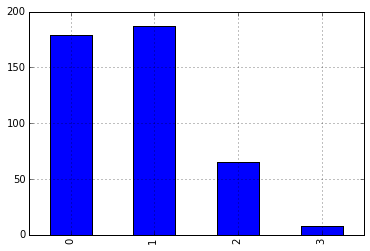

In [520]:
missing_values = data.isnull().sum(axis=1)
missing_groups = missing_values.groupby(missing_values.values).size()
missing_groups.plot(kind='bar')
missing_groups

Чаще всего у объекта отсутствует только один признак. Нет ни одного объекта, у которого пропущено больше 3 признаков.

Посмотрим на статистику о данных:

In [521]:
data.describe()

,a,b,c,d,e
count,350.000000,375.000000,368.000000,404.000000,357.000000
mean,1931520.328571,872379.480000,2188.179348,46544.349010,35593.725490
std,3706373.503441,2957194.665734,4620.451613,21411.213027,181819.857097
min,444.000000,9.000000,0.000000,0.000000,1.000000
25%,111216.250000,6415.500000,130.000000,32090.250000,132.000000
50%,632400.000000,32700.000000,475.000000,44939.500000,784.000000
75%,1970495.750000,222177.500000,1800.000000,60289.250000,2516.000000
max,27057179.000000,21245399.000000,35000.000000,101295.000000,1918620.000000


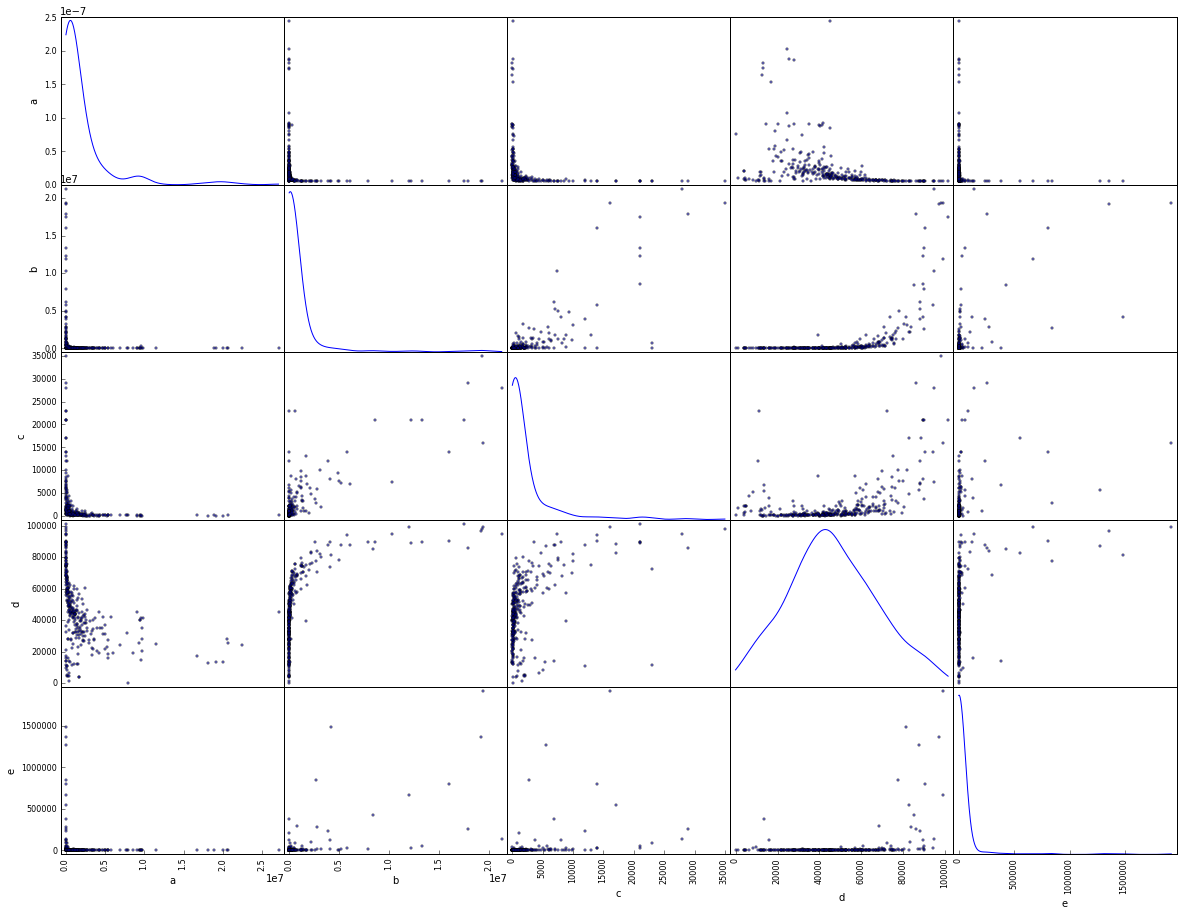

In [595]:
scatter_matrix(data, figsize=(20, 15), diagonal='kde');

Все признаки заданы целыми натуральными числами, данные не нормированы, у признака $a$ наибольший разброс. Добавим к имеющимся признакам новые, которые получаются взятием логарифма имеющихся.

In [594]:
extended_data = data.copy()
for c in extended_data.columns:
    extended_data["log_{}".format(c)] = np.log1p(data[c])

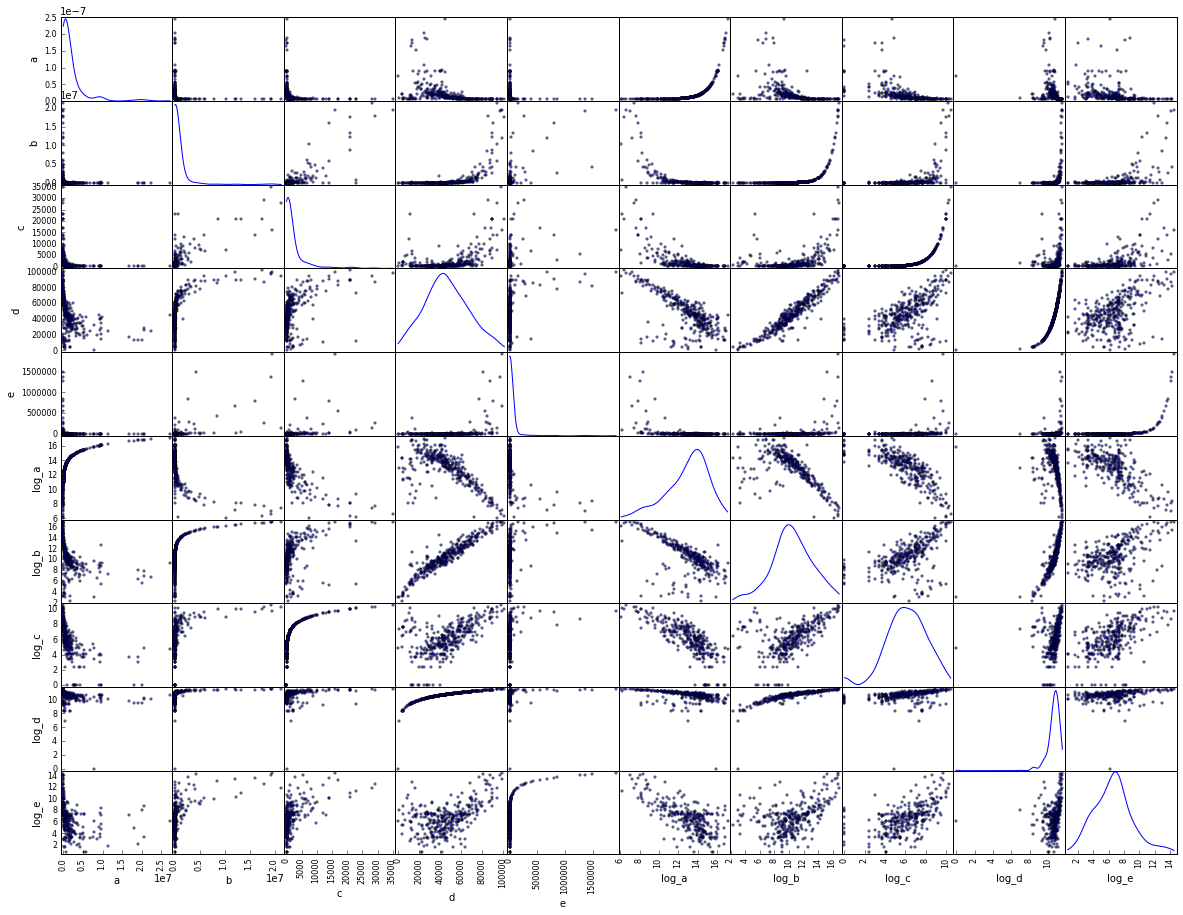

In [524]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(extended_data, figsize=(20, 15), diagonal='kde');

Видно, что $log(1 + a)$ и $log(1 + b)$ практически линейно зависят от $d$:

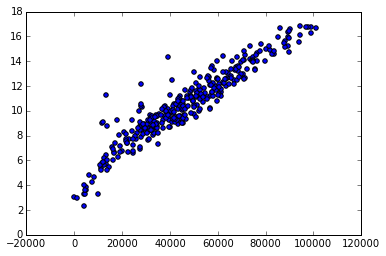

In [525]:
scatter(extended_data.d, extended_data.log_b);

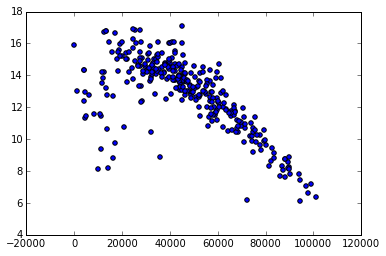

In [526]:
scatter(extended_data.d, extended_data.log_a);

По виду зависимости $log(1+a)$ от $d$ можно предположить, что выборка неоднородна, то есть для большей части точек верна линейная зависимость, но есть часть точек с другим распределением.

Чтобы проверить эту гипотезу выделим 2 главные компоненты и визуализируем их:

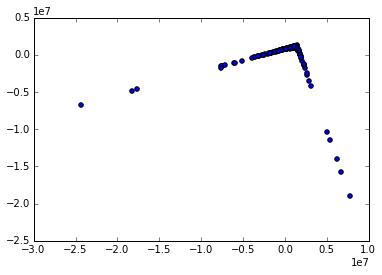

In [529]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data.dropna())
scatter(*(data_2d.T));

Доля дисперсии, объясненной двумя главными компонентами:

In [530]:
pca.explained_variance_ratio_.sum()

0.99962555452385982

На первый взгляд это просо отлично, но стоит помнить, что данные не были нормированны, поэтому доля объяненной дисперсии завышена.

Видно, что данные состоят из двух линейных ветвей. В качестве точки сочленения можно взять точку с максимальным значением второй главой компоненты:

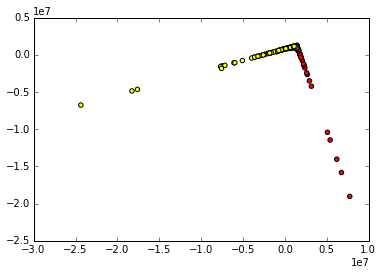

In [531]:
joint_idx = data_2d.argmax(axis=0)[1]
joint = data_2d[joint_idx]
branch_idx = (data_2d[:, 0] < joint[0])
scatter(*(data_2d.T), c=branch_idx);

Для каждой ветви построим линейное приближение методом наименьших квадратов:

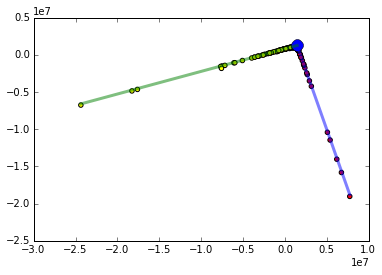

In [532]:
from sklearn.linear_model import LinearRegression
branches = [LinearRegression() for _ in [0, 1]]
scatter(*(data_2d.T), c=branch_idx);
plot(joint[0], joint[1], 'bo', markersize=12)
directions = []
for idx, branch in enumerate(branches):
    points = data_2d[branch_idx == idx]
    branch.fit(points[:, 0, np.newaxis], points[:, 1, np.newaxis])
    dx = (points[:, 0].max() - points[:, 0].min()) * [1, -1][idx]
    dy = branch.coef_ * dx
    directions.append(np.array((dx, dy), dtype=float))
    plot((joint[0], joint[0] + dx),
         (joint[1], joint[1] + dy),
         linewidth=3,
         alpha=0.5);

В результате получим такой алгоритм заполнения пропущенных данных:  
каждая точка $\vec{x}$ должна лежать на какой-то ветви. Известны направляющие векторы каждой ветви $\vec{l_i}, i \in \{1, 2\}$, для каждого из которых требуется найти такое $k_i$, чтобы вектор $k_i \vec{l_i} + \vec{l_0}$ как можно лучше приближал известные компоненты $\vec{x}$. $\vec{l_0}$ - точка сочленения ветвей.  
Будем минимизировать по $k_i$ функционал $\sum_{t: x^t \ne NaN}(x^t - (l_0^t + k_i l_i^t))^2$, где надстрочным индексом обоначены $t$-ые компоненты соответствующих векторов. Обозначим $\vec{M} = (m^1 \dots m^p)$, где $m^t = [x^t \ne NaN]$, $[k]$ - индикатор того, что утверждение $k$ верно. После этого заменим в $\vec{x}$ все $NaN$ на $0$.  
В результате необходимо минимизировать 
$ ||(\vec{x} - \vec{l_0} - k_i \vec{l_i}) * \vec{M}||^2 $, где $*$ - покомпонентное умножение векторов.  
Минимум дотигается при $k_i = \frac{((\vec{x} - \vec{l_0}) * \vec{M}, \vec{l_i} * \vec{M})}{||\vec{l_i} * \vec{M}||^2}$, где $(\vec{a}, \vec{b})$ - скалярное произведение векторов, $||\vec{v}||$ - евклидова норма вектора $\vec{v}$.

In [534]:
initial_center = pca.inverse_transform(joint)
initial_directions = [pca.inverse_transform(i) for i in directions]

In [535]:
initial_directions

[array([  1705616.13070135,  21780065.57442008,     30426.32993618,
           120009.52858987,    362198.89296095]),
 array([  2.87761285e+07,   6.29836123e+05,  -1.85603967e+03,
          3.44091942e+03,  -9.36307422e+03])]

In [536]:
initial_center

array([  6506.07284097,   2237.70351374,   1373.64749769,  45781.33820179,
         9371.19896322])

In [623]:
def project(vector, direction):
    return vector.dot(direction) / direction.dot(direction)
def error(x, y):
    d = x - y
    return d.dot(d)

class Filler:
    def __init__(self):
        self._center = array([6506.07284097,
                              2237.70351374,
                              1373.64749769,
                              45781.33820179,
                              9371.19896322])
        self._directions = [array([1705616.13070135,
                                   21780065.57442008,
                                   30426.32993618,
                                   120009.52858987,
                                   362198.89296095]),
                            array([2.87761285e+07,
                                   6.29836123e+05,
                                   -1.85603967e+03,
                                   3.44091942e+03,
                                   -9.36307422e+03])]
    def predict_point(self, point):
        mask = ~np.isnan(point)
        filled_point = np.nan_to_num(point)
        projections = [project((filled_point - self._center) * mask,
                               direction * mask) 
                       for direction in self._directions]
        predictions = [(projection * direction + self._center).astype(int)
                       for projection, direction in zip(projections, self._directions)]
        errors = [error(prediction * mask, filled_point) 
                  for prediction in predictions]
        prediction = predictions[np.argmin(errors)]
        prediction[prediction < 0] = 0
        return filled_point * mask + prediction * ~mask
    def predict(self, X):
        answer = np.zeros(X.shape)
        for idx, point in enumerate(X):
            answer[idx] = self.predict_point(point)
        return answer

def get_test_data(data, threshold):
    result = data.copy().astype(float)
    result.iloc[np.random.sample(result.shape) < threshold] = np.NaN
    return result

def test_filler(filler, data, threshold):
    answer = data
    test_data = get_test_data(data, threshold)
    filler_answer = filler.predict(test_data.values)
    return ((filler_answer - answer)**2).mean()
    
f = Filler()
f.predict_point(p)
train_data = data.dropna()
np.sqrt(test_filler(f, train_data, threshold=0.33))

a    5130697.000204
b     875103.528176
c       1931.359632
d      10960.813213
e      52135.814422
dtype: float64

Сравним заполненную часть выборки с изначально известной частью:

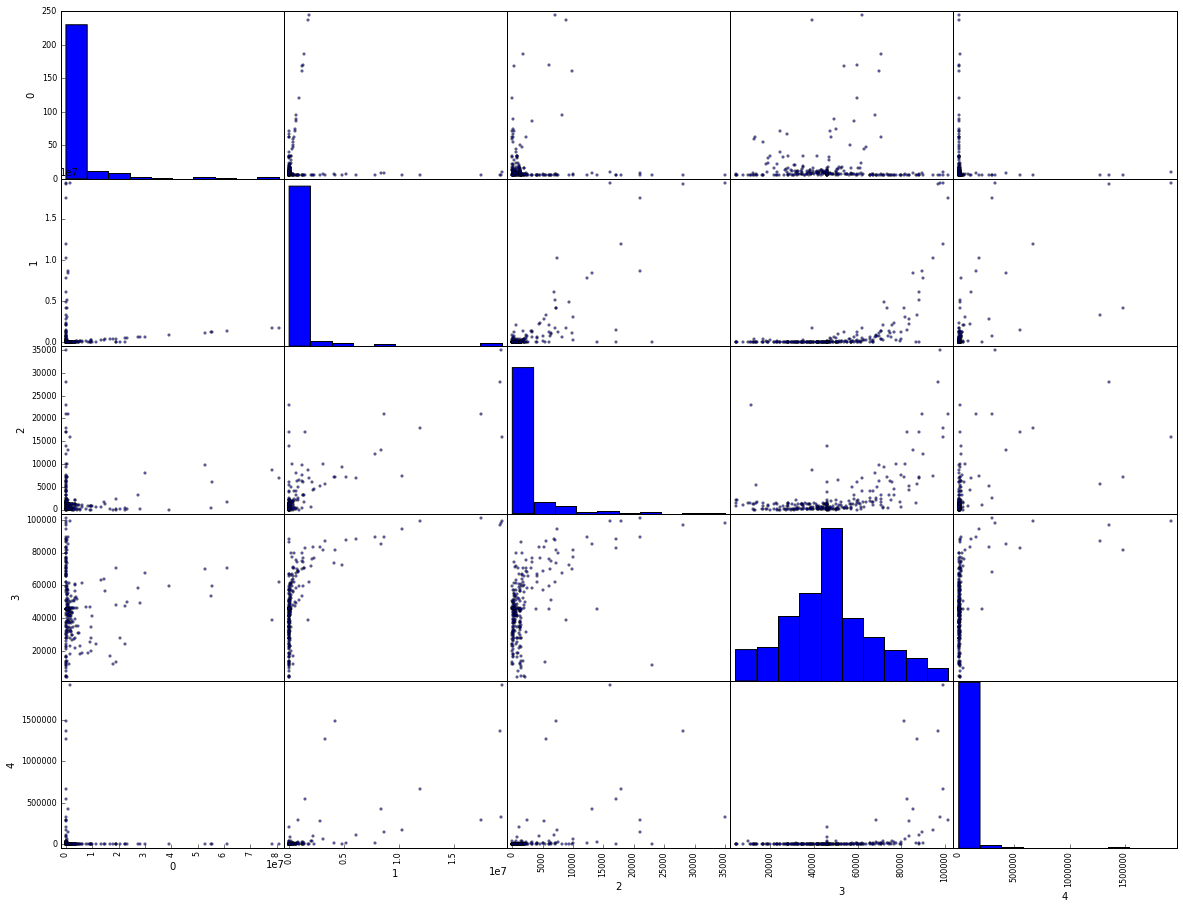

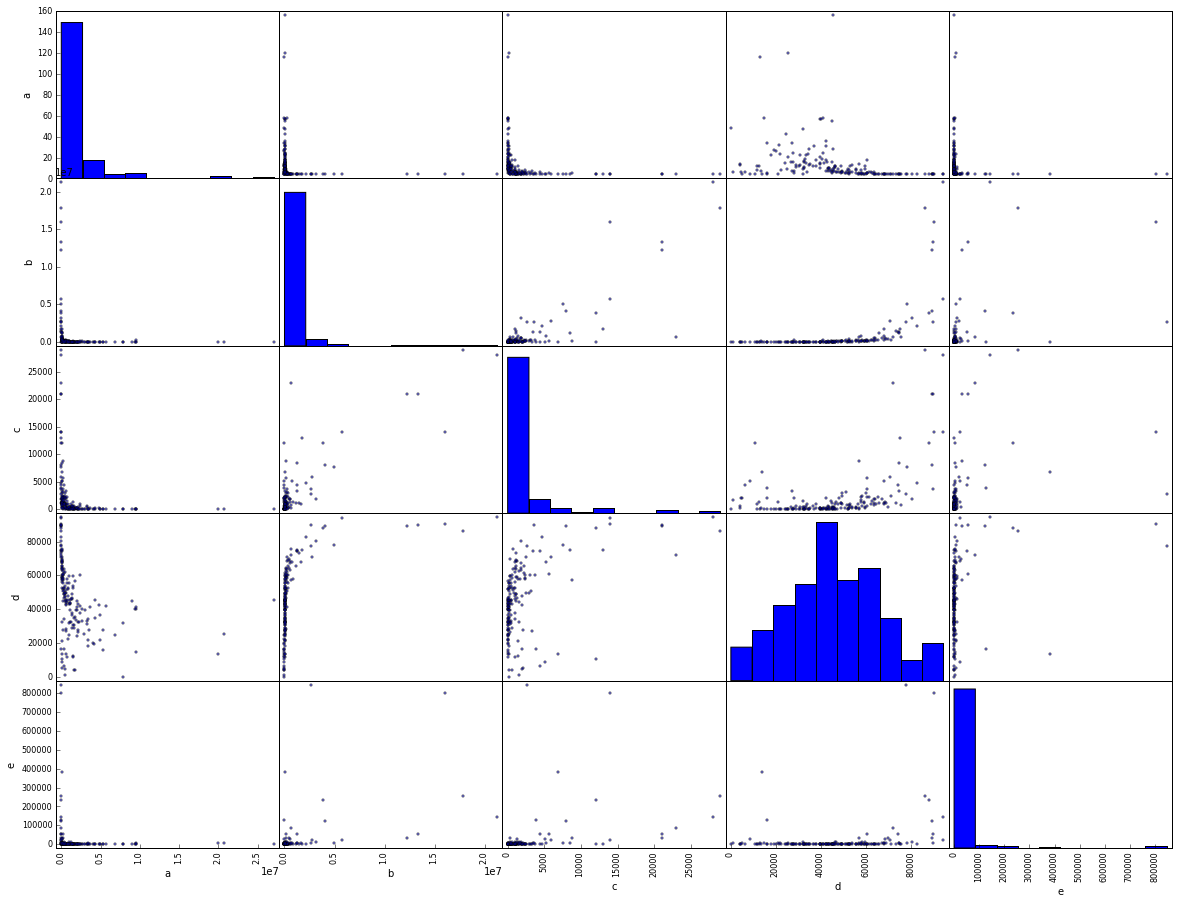

In [614]:
prediction = pd.DataFrame(f.predict(data.ix[missing_values > 0].values))
scatter_matrix(prediction, figsize=(20, 15));
show()
scatter_matrix(data.ix[missing_values == 0], figsize=(20, 15));

В основном совместные распределения выглядят одинаково, кроме распределений $a$ и $b$ и $a$ и $d$.

In [598]:
prediction.describe()

,0,1,2,3,4
count,260.000000,260.000000,260.000000,260.000000,260.000000
mean,3985465.744746,777758.985005,2300.017633,47168.105661,42653.675345
std,10898496.272211,2720646.141247,4534.110759,20280.244964,199717.596532
min,0.000000,0.000000,0.000000,4220.000000,0.000000
25%,72566.677319,5423.750000,207.500000,34602.000000,375.750000
50%,621068.500000,25999.901758,752.996002,45830.452925,1665.000000
75%,2127221.250000,213228.235516,1700.000000,59270.500000,9245.563320
max,80734903.513993,19349337.000000,35000.000000,101295.000000,1918620.000000


In [585]:
data.ix[missing_values == 0].describe()

,a,b,c,d,e
count,179.000000,179.000000,179.000000,179.000000,179.000000
mean,1780825.608939,768670.156425,2153.324022,45738.396648,20062.994413
std,3421357.809584,2797727.030679,4609.981170,21028.638705,95588.283493
min,481.000000,9.000000,0.000000,0.000000,1.000000
25%,120065.500000,8116.000000,115.000000,32057.500000,88.500000
50%,596662.000000,35356.000000,500.000000,45192.000000,689.000000
75%,1839045.000000,202182.500000,1800.000000,59616.500000,2524.000000
max,27057179.000000,21245399.000000,29000.000000,94377.000000,846185.000000


Статистические характеристики двух выборок похожи, поэтому можно предположить адекватность построенного алгоритма.
В условии не была задана метрика качества, поэтому минимизировалось MSE.  
Для ненормированных данных это не адекватная метрика. Если нормировать данные, то изменится структура выборки в главных компонентах. Тогда можно искать наилучшее приближение точки, для которой известно $p$ признаков, в линейном пространстве, образованном $p$ первыми главными компонентами. Этот метод хорошо работает только когда у первых главных компонент достаточно высокая доля объясненной дисперсии. Для этого приходится использовать логарифмы нормированных признаков, а минимизация среднеквадратичной ощибки для логарифмов дает очень большую ошибку для исходных нормированных признаков.